<a id='04-nb'></a>

# Music Recommender Part 4: Deploy Model & Inference using Online Feature Store

----

In this notebook, we'll deploy our chosen model as an endpoint so that we can make predictions/inferences against it. 
Under the hood the *model.deploy* function creates a model, an endpoint configuration and an endpoint. 

Then we'll make music recommendations for a single user by inferencing against our model. We'll query our Feature Store to get some data to use for inferencing and show you how [SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-model-explainability.html) can explain which features were most useful in making the recommended music predictions using SHAP values.

Amazon SageMaker Clarify provides tools to help explain how machine learning models make predictions. These tools can help ML modelers and developers and other internal stakeholders understand model characteristics as a whole prior to deployment and to debug predictions provided by the model after it's deployed. Transparency about how ML models arrive at their predictions is also critical to consumers and regulators who need to trust the model predictions if they are going to accept the decisions based on them.

----
### Contents
- [Overview](00_overview_arch_data.ipynb)
- [Part 1: Data Prep using Data Wrangler](01_music_dataprep.flow)
- [Part 2a: Feature Store Creation - Tracks](02a_export_fg_tracks.ipynb)
- [Part 2b: Feature Store Creation - User Preferences](02b_export_fg_5star_features.ipynb)
- [Part 2c: Feature Store Creation - Ratings](02c_export_fg_ratings.ipynb)
- [Part 3: Train Model with Debugger Hooks. Set Artifacts and Register Model.](03_train_model_lineage_registry_debugger.ipynb)
- [Part 4: Deploy Model & Inference using Online Feature Store](04_deploy_inference_explainability.ipynb)
    - [Deploy model](#04-deploy)
    - [Create predictor](#04-predictor)
    - [Infer new songs](#04-infer)
    - [Explain model predictions](#04-explain)
- [Part 5: Model Monitor](05_model_monitor.ipynb)
- [Part 6: SageMaker Pipelines](06_pipeline.ipynb)
- [Part 7: Resource Cleanup](07_clean_up.ipynb)

In [1]:
try:
    !pip install -U awswrangler
except ModuleNotFoundError:
    !pip install --no-input awswrangler

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
# update pandas to avoid data type issues in older 1.0 version
!pip install -q pandas==1.2.0
import pandas as pd
print(pd.__version__)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
1.2.0


In [3]:
import time
import boto3
import argparse
import pathlib

import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.estimator import Estimator
import awswrangler as wr

import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import sys
import pprint
sys.path.insert(1, './code')
from parameter_store import ParameterStore
ps = ParameterStore(verbose=False)

parameters = ps.read('music-rec')

bucket = parameters['bucket']
dw_ecrlist = parameters['dw_ecrlist']
fg_name_ratings = parameters['fg_name_ratings']
fg_name_tracks = parameters['fg_name_tracks']
fg_name_user_preferences = parameters['fg_name_user_preferences']

flow_export_id = parameters['flow_export_id']
flow_s3_uri = parameters['flow_s3_uri']
pretrained_model_path = parameters['pretrained_model_path']
prefix = parameters['prefix']
ratings_data_source = parameters['ratings_data_source']
tracks_data_source = parameters['tracks_data_source']
model_name = parameters['model_name']
training_job_name = parameters['training_job_name']
mpg_name = parameters['mpg_name']
model_name = parameters['model_name']
feature_names = parameters['feature_names']
train_data_uri = parameters['train_data_uri']
endpoint_name = '{}-endpoint-notebooks'.format(model_name)
print(endpoint_name)

ps.add({'endpoint_name':endpoint_name}, namespace='music-rec')
ps.store()


music-recommendation-model-endpoint-notebooks
date and time = 05/08/2021 06:40:21


In [5]:
sess = sagemaker.Session()
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)

s3_client = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity()["Account"]

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)

sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client
)

sagemaker_role = sagemaker.get_execution_role(sagemaker_session=sagemaker_session)

<a id='04-deploy'></a>

## Deploy Model

##### [back to top](#04-nb)

----

In [6]:
# if you want to use a pretrained model, set use_pretrained = True
## else use_pretrained = False to use the model you trained in the previous notebook
use_pretrained = False

if use_pretrained:
    # or use a pretrained model if you skipped model training in the last notebook
    xgb_estimator = sagemaker.model.Model(
        image_uri=sagemaker.image_uris.retrieve("xgboost", region, "0.90-2"),
        model_data=pretrained_model_path,
        role=sagemaker_role
    )
else:
    print(training_job_name)
    # reinstantiate the estimator we trained in the previous notebook
    xgb_estimator = Estimator.attach(training_job_name)


music-recommendation-model-2021-08-05-06-19-44-755

2021-08-05 06:40:16 Starting - Preparing the instances for training
2021-08-05 06:40:16 Downloading - Downloading input data
2021-08-05 06:40:16 Training - Training image download completed. Training in progress.
2021-08-05 06:40:16 Uploading - Uploading generated training model
2021-08-05 06:40:16 Completed - Training job completed


In [7]:
endpoint_list = sagemaker_client.list_endpoints(
    SortBy='CreationTime',
    SortOrder='Descending',
    NameContains=endpoint_name,
    StatusEquals='InService'
)
endpoint_list

{'Endpoints': [{'EndpointName': 'music-recommendation-model-endpoint-notebooks',
   'EndpointArn': 'arn:aws:sagemaker:us-east-2:738335684114:endpoint/music-recommendation-model-endpoint-notebooks',
   'CreationTime': datetime.datetime(2021, 8, 5, 6, 31, 52, 643000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2021, 8, 5, 6, 38, 2, 954000, tzinfo=tzlocal()),
   'EndpointStatus': 'InService'}],
 'NextToken': 'cIws2QhTXUIa8bi8WqnvV4N1YqMOHlD7jElQ14IwjIiM23XR+iTNwl0QRUs3sqoGPqYMA5Qz9DbA31zJ8Dtf785YU/1/Job3V3akido1KSDqHvVM65+T+fn0QQTY3Af9qLoiQgjgtAUoMVouRB8zFy+5mauEFB6p9hOi/xmhq39rQmE0ta/sk8S8wCquTPbxE1q+53sVxtu/B8eT2+La+VlhwdsEQf7+ZVsIbFj2UP34LQ1mtvwp3E+Oy8RULSoX2BaU9kcwEXe6dai3KfAU5FuTadQmI5fikQIZFX5tjPO2VYo0wxIHNy7j+fmwNwseJdrpHWILQzx/chdNuORpQrWl6maUgbJQx3BwGlwPunsTERAOAZrUJElL5mbRYFvEGzNvUYS2hmyiQNnq7F0PBQXGG1zZRnZ+MDtX8aKsvtOBnsbPj8Uipnn3eS0DhojCG5DKOWUL25xTE8Wk6M54DIniNBxAO6WseKdoPAluUrivT5Q3TtrWcCGI7XdbRNKtpd4QdBHXcCoVvJdDmvqQhP47Z588i9+b/FcGQOr5iKxiAT4TSl497HzRxHY/qf

### Create endpoint

In [8]:
%%time
if len(endpoint_list['Endpoints']) > 0:
    print(f"Using existing endpoint: {endpoint_list['Endpoints'][0]['EndpointName']}")
else:
    # deploy endpoint for model if it doesn't already exist
    xgb_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.m4.xlarge',
                         model_name=model_name,
                         endpoint_name=endpoint_name
                         )

Using existing endpoint: music-recommendation-model-endpoint-notebooks
CPU times: user 615 µs, sys: 92 µs, total: 707 µs
Wall time: 615 µs


In [9]:
model_package = sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)['ModelPackageSummaryList'][0]
model_package_update = {
    'ModelPackageArn': model_package['ModelPackageArn'],
    'ModelApprovalStatus': 'Approved'
}

update_response = sagemaker_client.update_model_package(**model_package_update)

<a id='04-predictor'> </a>

## Create a predictor

##### [back to top](#04-nb)

----

In [10]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session)

### Pull user data from feature group

In [11]:
# random user ID. You can try any other ID
sample_user_id = 11005

In [12]:
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

In [13]:
# pull the sample user's 5 star preferences record from the feature store
fg_response = featurestore_runtime.get_record(
    FeatureGroupName=fg_name_user_preferences, 
    RecordIdentifierValueAsString=str(sample_user_id)
)

record = fg_response['Record']
df_user = pd.DataFrame(record).set_index('FeatureName')

### Pull sample of 1000 tracks from feature group

In [14]:
# pull a sample of the tracks data (multiple records) from the feature store using athena query
fg_name_tracks_obj = FeatureGroup(name=fg_name_tracks, sagemaker_session=feature_store_session)
tracks_query = fg_name_tracks_obj.athena_query()
tracks_table = tracks_query.table_name

# use escaped quotes aound table name since it contains '-' symbols
query_string = ("SELECT * FROM \"{}\" LIMIT 1000".format(tracks_table))
print("Running " + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
tracks_query.run(query_string=query_string, output_location=f"s3://{bucket}/{prefix}/query_results/")
tracks_query.wait()
df_tracks = tracks_query.as_dataframe()

Running SELECT * FROM "track-features-music-rec-1628139447" LIMIT 1000


In [15]:
data = df_tracks.merge(pd.DataFrame(df_user['ValueAsString']).T, how='cross')
data.columns = [c.lower() for c in data.columns]
inference_df = data[feature_names]

### Format the datapoint
The datapoint must match the exact input format as the model was trained--with all features in the correct order. In this example, the `col_order` variable was saved when you created the train and test datasets earlier in the guide.

In [16]:
data_inputs = [','.join([str(i) for i in row]) for row in inference_df.values]

<a id='04-infer'> </a>

## Infer (predict) new songs using model

##### [back to top](#04-nb)

----

In [17]:
predictions = []
for data_input in data_inputs:
    results = predictor.predict(data_input, initial_args = {"ContentType": "text/csv"})
    prediction = json.loads(results)
    predictions.append(prediction)
print(f'Predicted rating for user {int(sample_user_id)}:', prediction)

Predicted rating for user 11005: 2.9320945739746094


In [18]:
# Write to csv in S3 without headers and index column.
inference_df['rating'] = predictions
inference_df = inference_df[['rating']+feature_names]
inference_df.to_csv('data/prediction_data.csv', header=False, index=False)

s3_client.upload_file('data/prediction_data.csv', bucket, f'{prefix}/data/pred/prediction_data.csv')

pred_data_uri = f's3://{bucket}/{prefix}/data/pred/prediction_data.csv'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df_train = pd.read_csv(train_data_uri)

label = 'rating'

<a id='04-explain'> </a>

## Explain model predictions

##### [back to top](#04-nb)

----

In [20]:
explainability_output_path = f's3://{bucket}/{prefix}/clarify-output/explainability'

In [21]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    sagemaker_session=sagemaker_session)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m4.xlarge',
    instance_count=1,
    accept_type='text/csv')

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[df_train.median().values[1:].tolist()],  # ignore the first column since that is that target
    num_samples=100,
    agg_method='mean_abs')

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=pred_data_uri,
    s3_output_path=explainability_output_path,
    label=label,
    headers=[label]+feature_names,
    dataset_type='text/csv')


In [22]:
%%time
try:
    s3_client.download_file(
        Bucket   = bucket, 
        Key      = f'{prefix}/clarify-output/explainability/explanations_shap/out.csv', 
        Filename = 'data/shap_output.csv'
    )
    print('Downloaded output from previous explainability job')
except Exception as e:
    error = e.response.get('Error').get('Code')
    if error == '404':
        print('Running explainability job')
        clarify_processor.run_explainability(
            data_config=explainability_data_config,
            model_config=model_config,
            explainability_config=shap_config)

Running explainability job

Job Name:  Clarify-Explainability-2021-08-05-06-40-45-051
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-738335684114/music-recommendation/data/pred/prediction_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-738335684114/music-recommendation/clarify-output/explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-738335684114/music-recommendation/clarify-output/explainability', 'LocalPath': '/opt/ml/processing/

In [23]:
inference_df['trackid'] = data['trackid']

In [24]:
playlist_length = 10  # number of songs to recommend in playlist
playlist = inference_df.sort_values(by='rating', ascending=False).head(playlist_length)
print('Curated Playlist:\n', playlist['trackid'])

Curated Playlist:
 926    d3e8fab6-09d4-4737-a8d1-52761aad71c7
541    e4767b66-6b5d-4844-a5c4-05fb68ab4c3d
612    b4cc4b2f-b54a-4697-b829-f392f1da1853
499    abc3a1d5-3404-49b3-885b-fbaef87ee4b0
604    7210b04b-2402-4978-b71d-6901629d8195
996    f5bfcfda-8a32-419c-bb5f-f01ed6b836e7
148    4ef61910-df56-4d3f-ae20-33221e0f0838
211    7366cc7c-99fd-4758-8a52-c1c90373e8c4
624    7f22d50f-1380-436f-9ac5-994054181de9
475    c6160b43-257a-4941-bae4-e2addeed1289
Name: trackid, dtype: object


Model prediction: 5.451362133026123


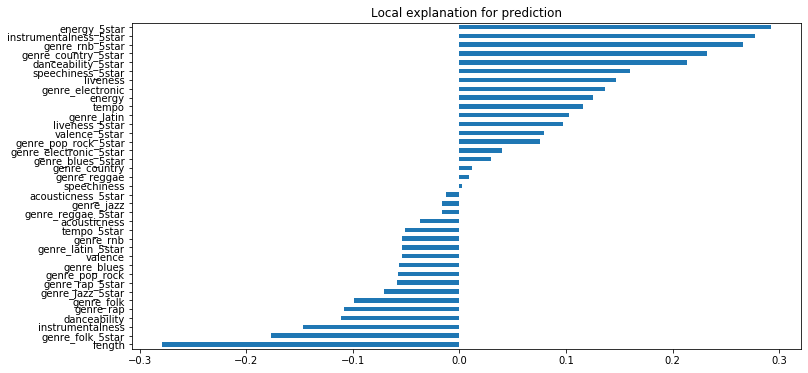

In [25]:
local_explanations_out = pd.read_csv(explainability_output_path+'/explanations_shap/out.csv')
local_explanations_out.columns = feature_names

print("Model prediction:", playlist.iloc[0, 0])
plt.figure(figsize=(12,6))
local_explanations_out.iloc[0].sort_values().plot.barh(title='Local explanation for prediction')